# Interpreting White-Boxes: Building a Decision Engine

## Introduction

In general white-box models are intrinsically interpretable. In other words, the mechanism used by the model to make the decision is more transparent and easy to explain in non-technical terms than complex tree-based models and neural networks. __Decision engines__ are pipelines that are specially programmed with __business rules__ that are derived from __domain knowledge__. Many decision engines use a combination of business rules and machine learning to achieve more reliable results. Business rules define the criteria and constraints that the decision engine must follow, while machine learning provides the ability to learn from data and identify patterns and relationships in the information that is relevant to the decision being made.

In this lesson, we will use scikit-learn to build a decision engine that we can use in an urban development scenario to classify homes as McMansions. First, we will discuss the use-case and prepare you with some domain knowledge. Then, we will discuss how to formulate the business rules that define McMansions. Next, we will code those rules in Python and apply them to our training data. Then, we will use two white-box models in scikit-learn, logistic regression and decision trees, to build a decision engine for buying McMansions. Finally, we will review some of the techniques available in scikit-learn to interpret the results of our model. Most importantly, we will explain how the pieces of the decision engine work together to achieve interpretable results.

## Objectives

You will be able to:

* Describe a decision engine and how they use business rules and machine learning to automate decisions
* Build a decision engine in scikit-learn using business rules and white-box models
* Generate metrics to interpret and evaluate results of decision engine
* Create a high level explanation based on metrics and domain knowledge. 

## Building a Decision Engine to Buy McMansions

Decision engines automate decision making by using two kinds of inputs, business rules and machine learning. The rationale for using both is that combining them can yield more interpretable results. Here are some reasons why:

* Business rules may provide a baseline decision based on predefined criteria and can act as a default decision when machine learning models are uncertain.
* Machine learning models may be used to provide additional insight and suggest modifications to the business rules, based on the data and patterns that they have learned from previous decisions.
* This combination allows decision engines to be both flexible and consistent in their decision-making, combining the strengths of both business rules and machine learning.

The general process for building the decision engine will be as follows:
1. Gather domain knowledge
2. Determine methodology
3. Select training data
4. EDA/Encode business rules
6. Preprocessing/label training data
7. Train regression model
8. Train decision tree

Let's get to work!


### 1. Gather Domain Knowledge
McMansions are large, mass-produced houses built in suburban areas with a focus on size rather than architectural design. They are often criticized for their lack of aesthetic appeal and poor construction quality. They also tend to be overpriced relative to similar homes in the same area, making them a bad investment. Additionally, their cookie-cutter design can result in declining property values and decreased demand, further reducing their investment potential.

Consider the following scenario:

McMansions became popular in the late 1980s and 1990s and saw a surge in popularity through the early 2000s, especially in suburban areas. The trend was driven by a strong housing market, low interest rates, and a desire for larger homes with more amenities. The popularity of McMansions declined after the 2008 housing crisis, as more home buyers shifted towards smaller, more sustainable, and energy-efficient homes. Since many McMansions are reaching the end of their lifespan, there is a lot of talk about what to do with all of the suburban sprawl that will need to be replaced.

Suppose you work for an urban planning firm, that is tasked with identifying potential sights for a new mixed-use walkable neighborhood district to replace a large swath of aging McMansions. You decide that the best way to do this is to train a model to evaluate real-estate listings and create a list McMansions you would like to buy. Is there a way that you can build a decision engine that can automate the task of determining if a home is a McMansion, estimating the current market value, and decide if it belongs on the list?

Since we do not have labeled data to classify the homes, we will have to apply labels to our training data using __business rules__ based on our __domain knowledge__ of McMansions. Then, we can use machine learning to automate that decision on future datasets, as well as learn about what other features are common among our target. 

While we may not be able to find all of these features in the data, there are some of the quintessential features that make a house a McMansion that we can distill into simple rules:

* Single-family homes
* Built between 1980 and 2010
* 2,000+ square feet
* Sale price in the upper quartile for that neighborhood

Now that we know what a McMansion is, let's try to find some.

### 2. Determine Methodology
To build the decision engine, we need to use logic to break the task down into smaller steps. Later on, this will help us to explain the decision mechanism. Broadly, this is our approach:

1. First, we need to identify examples of our target class using domain knowledge to encode business rules apply them to the training data to create the target variable `IS_MCMANSION`.

2. Then, we need to train a classifier (in this case, logistic regression) to identify McMansions in our test dataset.

3. Then, we will train a decision tree classifier to identify McMansions in our dataset.

Since we have articulated our methodology, we can select and import some training data. Then, we will tackle the first task of identifying and labeling the target class.

### 3. Select and Import Training Data
To train our model, we are going to use the __Ames Housing Dataset__. In the cell below, we will import the data, then we will do some quick EDA and apply our business rules. For this lesson, we are keeping the EDA simple to focus more on model interpretability. In practice, you would want to do a more thorough EDA to customize your preprocessing for your use case. Building models is also an iterative process, so you will often return to tweak preprocessing steps if you find that certain choices have interfered with the results. 

In [1]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("housing_prices.csv", na_values='?')

### 4. Conduct EDA and Implement Business Rules
How can we code rules to identify McMansions in the training data? 

First, we identify the features that correspond the rules we want to check. Then, we use conditional logic to create columns with binary indicators that flag rows which have the correct values. For expediency, we have located the relevant features in the data and demonstrates how to derive the new features.

For a detailed description of all the features, uncomment the cell below to read the data description.

In [3]:
import pprint
pp = pprint.PrettyPrinter(indent=4)

with open('data_description.txt') as f:
    lines = f.readlines()

text = []
for line in lines:
    line=line.strip().replace('\n', '')
    line=line.strip().replace('\t', '')
    if len(line) > 0:
        text += [line]
pp.pprint(text)

[   'MSSubClass: Identifies the type of dwelling involved in the sale.',
    '201-STORY 1946 & NEWER ALL STYLES',
    '301-STORY 1945 & OLDER',
    '401-STORY W/FINISHED ATTIC ALL AGES',
    '451-1/2 STORY - UNFINISHED ALL AGES',
    '501-1/2 STORY FINISHED ALL AGES',
    '602-STORY 1946 & NEWER',
    '702-STORY 1945 & OLDER',
    '752-1/2 STORY ALL AGES',
    '80SPLIT OR MULTI-LEVEL',
    '85SPLIT FOYER',
    '90DUPLEX - ALL STYLES AND AGES',
    '1201-STORY PUD (Planned Unit Development) - 1946 & NEWER',
    '1501-1/2 STORY PUD - ALL AGES',
    '1602-STORY PUD - 1946 & NEWER',
    '180PUD - MULTILEVEL - INCL SPLIT LEV/FOYER',
    '1902 FAMILY CONVERSION - ALL STYLES AND AGES',
    'MSZoning: Identifies the general zoning classification of the sale.',
    'AAgriculture',
    'CCommercial',
    'FVFloating Village Residential',
    'IIndustrial',
    'RHResidential High Density',
    'RLResidential Low Density',
    'RPResidential Low Density Park',
    'RMResidential Medium Density',


#### Rule 1: McMansions are single family homes
In this data, we can find that using the `BldgType` field. Let's check which value would correspond with single family homes, and get a sense of how often it appears in the data. 

In [4]:
print(df["BldgType"].value_counts())

BldgType
1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: count, dtype: int64


It seems that there are a lot of single family homes, represented by the value `1Fam`. Let's create a column that applies this rule to every row.

In [5]:
df["SINGLE_FAMILY"] = df["BldgType"].apply(lambda x: 1 if x == "1Fam" else 0)

#### Rule 2: McMansions are built between 1980 and 2010
In this data, we can find that using the `YearBuilt` field. Let's check which value would corresponds with our date range. 

In [6]:
print(df["YearBuilt"].value_counts())

YearBuilt
2006    67
2005    64
2004    54
2007    49
2003    45
        ..
1875     1
1911     1
1917     1
1872     1
1905     1
Name: count, Length: 112, dtype: int64


Great! Now, let's apply some logic to determine which houses were built within our date range, and turn that into a binary indicator.

In [7]:
df["IN_DATE_RANGE"] = df["YearBuilt"].apply(lambda x: 1 if (x >= 1980 and x <=2010) else 0)
print(df["IN_DATE_RANGE"].value_counts())

IN_DATE_RANGE
0    848
1    612
Name: count, dtype: int64


#### Rule 3: McMansions are Greater than 2,000 sq. ft.
In this data, we get the "above grade" (or "above ground") square footage with the `GrLivArea` field. 

In [8]:
print(df["GrLivArea"].value_counts())

GrLivArea
864     22
1040    14
894     11
1456    10
848     10
        ..
2296     1
1123     1
1199     1
1473     1
1256     1
Name: count, Length: 861, dtype: int64


In [9]:
df["ABOVE_2K_SQFT"] = df["GrLivArea"].apply(lambda x: 1 if x >= 2000 else 0)
print(df["ABOVE_2K_SQFT"].value_counts())

ABOVE_2K_SQFT
0    1245
1     215
Name: count, dtype: int64


#### Sale Price
Now, we want to identify houses that sold for a lot more than other houses.

In [10]:
df["UPPER_QUARTILE"] = df["SalePrice"] >= df["SalePrice"].describe()["75%"]

In [11]:
df["UPPER_QUARTILE"].value_counts()

UPPER_QUARTILE
False    1093
True      367
Name: count, dtype: int64

#### Applying the Rules
Now that we have used domain knowledge to lay out the business rules and we created binary indicators to flag the rows that meet the criteria, we can create a new column that scores each row based on the number of criteria indicated.

In [12]:
df["MCMANSION_SCORE"] = df["UPPER_QUARTILE"] + df["ABOVE_2K_SQFT"] + df["IN_DATE_RANGE"] + df["SINGLE_FAMILY"]
print(df["MCMANSION_SCORE"].value_counts())

MCMANSION_SCORE
1    741
2    287
3    205
4    121
0    106
Name: count, dtype: int64


If we wanted to strictly interpret our rules, we would have __121 McMansions__. However, if we want to widen the net a bit, we could use a `MCMANSION_SCORE` greater than or equal to `3` as the threshold. Let's use that to create a binary indicator `IS_MCMANSON`.

In [13]:
df["IS_MCMANSION"] = df["MCMANSION_SCORE"] >= 3
print(df["IS_MCMANSION"].value_counts())

IS_MCMANSION
False    1134
True      326
Name: count, dtype: int64


Great! Now we have applied our business rules and identified __326 McMansions__. Let's also take note that we have a class imbalance of approximately 4 non-McMansions for every McMansion. This might have an impact on our results.

Now, let's train a model to identify our McMansions.

### 5. Preprocess and Label Data

#### Handling Nulls

Next, we have to do some minimal preprocessing to handle null values before passing the data through our model.

When imputing null values, there is no one size fits all technique. For certain use cases, it is appropriate to the mean, or the median. In other cases, it is better to indicate that the value is missing. For example `PoolArea` _should_ be zero if a house has no pool. 

In the cell below, we identify all the categorical and numerical variables. We will need to train test split and then handle nulls for both numerical and categorical.

In [14]:
# identify all of fields that have strings as values
categorical = [col for col in df.columns if df[col].dtype=="O"]
numerical = [col for col in df.columns if col not in categorical]

print(f"Total NaNs in Numerical Features: {sum(df[numerical].isna().sum())}")

print(f"Total NaNs in Categorical Features: {sum(df[categorical].isna().sum())}")

Total NaNs in Numerical Features: 348
Total NaNs in Categorical Features: 7481


In [15]:
# Identify columns with nulls
df[numerical].isna().sum()

Id                   0
MSSubClass           0
LotFrontage        259
LotArea              0
OverallQual          0
OverallCond          0
YearBuilt            0
YearRemodAdd         0
MasVnrArea           8
BsmtFinSF1           0
BsmtFinSF2           0
BsmtUnfSF            0
TotalBsmtSF          0
1stFlrSF             0
2ndFlrSF             0
LowQualFinSF         0
GrLivArea            0
BsmtFullBath         0
BsmtHalfBath         0
FullBath             0
HalfBath             0
BedroomAbvGr         0
KitchenAbvGr         0
TotRmsAbvGrd         0
Fireplaces           0
GarageYrBlt         81
GarageCars           0
GarageArea           0
WoodDeckSF           0
OpenPorchSF          0
EnclosedPorch        0
3SsnPorch            0
ScreenPorch          0
PoolArea             0
MiscVal              0
MoSold               0
YrSold               0
SalePrice            0
SINGLE_FAMILY        0
IN_DATE_RANGE        0
ABOVE_2K_SQFT        0
UPPER_QUARTILE       0
MCMANSION_SCORE      0
IS_MCMANSIO

It looks like these nulls should actually be 0's. The house in question does not have the feature being measured. We can fill in before splitting without any data leakage because we are using a 0 value.

In [16]:
# Fill in numerical nulls with 0
df[numerical] = df[numerical].fillna(0)

Now, let's look at the categorical variables.

In [17]:
df[categorical].isna().sum()

MSZoning            0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType        872
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinType2       38
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         0
Functional          0
FireplaceQu       690
GarageType         81
GarageFinish       81
GarageQual         81
GarageCond         81
PavedDrive          0
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
dtype: int64

Similiar to the numericals it looks like these nulls correspond to houses that do not have the associated features, we can fill in with 'N/A' before splitting and onehotencoding.

In [18]:
df[categorical] = df[categorical].fillna('N/A')

After these two steps, all of the null data has been handled. 

**Note:** We took a fairly simple and blanket approach here for simplicity and time, further invesigation of nulls is probably warranted.

In [19]:
df.isna().sum().sum()

0

### 6. Train Regression Model

To avoid data leakage and or overfitting, we are going to remove the indicators that were created to apply our business rules from the training data, now that it is labeled. Then, the data is split into the X (data) and y (target). 

In [20]:
drop = ["IS_MCMANSION", "MCMANSION_SCORE", "UPPER_QUARTILE", "ABOVE_2K_SQFT", "IN_DATE_RANGE", "SINGLE_FAMILY", "Id"]
keep = [col for col in df.columns if col not in drop]
X = df[keep]
y = df['IS_MCMANSION']

Next, we split out data into train and test sets. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Before we can model we need to handle the categorical variables by onehotencoding. Note again that this is a blanket approach for simplicity and time, some of these might warrant ordinal or target encoding instead.

In [22]:
# Import
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat = ohe.fit_transform(X_train[categorical])
X_test_cat = ohe.transform(X_test[categorical])

In [24]:
# Bring back togather
X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat.todense(), columns=ohe.get_feature_names_out(), index=X_test.index)
X_train = X_train.drop(columns=categorical)
X_train = X_train.join(X_train_cat)
X_test = X_test.drop(columns=categorical)
X_test = X_test.join(X_test_cat)

Finally, we fit a Logistic Regression classifier. We chose the "liblinear" solver because:
* It is efficient and scalable. This will be useful if we plan to use our model for larger datasets in the future. 
* It and can handle both L1 and L2 regularization, providing additional options for hypertuning the model. 
* It also supports both binary and multi-class classification.

In [25]:
model = LogisticRegression(solver="liblinear", max_iter=1000).fit(X_train, y_train)

### Evaluation and Interpretation
With our model fit, we can make predictions on test data and evaluate our results. Evaluation is an important part of interpretation, because it provides information about how confident we can be about our results.

In [26]:
# Predict using the model
y_pred = model.predict(X_test)

# Model accuracy
acc = model.score(X_test, y_test)
print("Accuracy: ", acc)

Accuracy:  0.9623287671232876


#### Model Agnostic Evaluation Metrics
Evaluation metrics like accuracy, precision, recall, and F1 can be used to evaluate any machine learning model. They can provide important information about the behavior of the model to help inform the interpretation/explanation.

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# Compute precision
prec = precision_score(y_test, y_pred)
print("Precision: {:.2f}%".format(prec * 100))

# Compute recall
rec = recall_score(y_test, y_pred)
print("Recall: {:.2f}%".format(rec * 100))

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 96.23%
Precision: 92.98%
Recall: 88.33%
F1 Score: 90.60%


##### What can we infer?
We can be fairly confident in the result, because the accuracy is pretty high. We have a higher precision than recall, which suggests that the model may be slightly more specific than sensitive. In other words, we are more likely to see a false negative than a false positive.

#### Visualize
Communicating these results can be more intuitive by using a visualization.

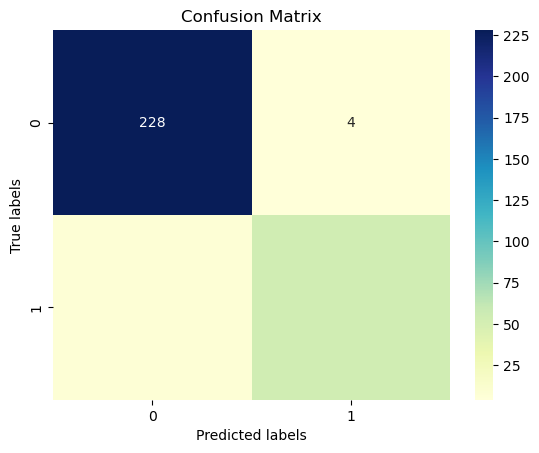

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### Coefficients
Coefficients in a logistic regression model represent the change in the log odds of the target variable for a one unit increase in the predictor variable, holding all other predictors constant. __In other words, the coefficient of a variable answers the question: "If I were to remove this variable, what are the odds that the model would still make the same decision?"__

A positive coefficient indicates that as the predictor increases, the log odds of the target variable also increases, and vice versa. A larger magnitude coefficient indicates a stronger relationship between the predictor and target. By interpreting coefficients, we can understand the impact of individual predictors on the target and how they relate to each other.

In [30]:
features = list(X.drop(columns=categorical).columns)
features_cat = list(ohe.get_feature_names_out())
features.extend(features_cat)

In [31]:
# access coefficients
coefs = model.coef_.tolist()[0]
coef_data = list(zip(features, coefs))
coef_df = pd.DataFrame(coef_data).round(3).sort_values(by=1, ascending=False)[:10]
print(coef_df.head(10))

                    0      1
5           YearBuilt  0.032
24        GarageYrBlt  0.009
34             MoSold  0.008
32           PoolArea  0.007
13           2ndFlrSF  0.007
22       TotRmsAbvGrd  0.003
20       BedroomAbvGr  0.003
168      ExterQual_Gd  0.003
12           1stFlrSF  0.003
177  Foundation_PConc  0.002


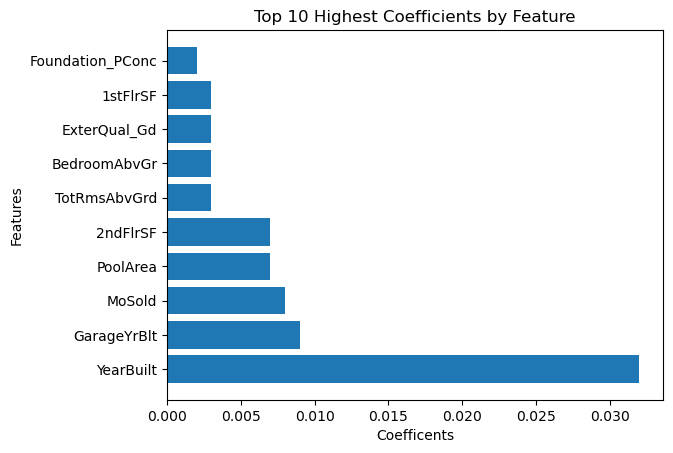

In [32]:
# plot coefficients
plt.barh(coef_df[0], coef_df[1])
plt.xlabel('Coefficents')
plt.ylabel('Features')
plt.title('Top 10 Highest Coefficients by Feature')
plt.show()

##### What can we infer?
Based on these coefficients, we can infer that the `YearBuilt` was the most important feature. We already knew that the year would be a defining criteria, based on our business rules.

Some of the other features were not explicitly part of our business rules, but make sense given our domain knowledge of McMansions. For example:

* `TotRmsAbvGrd` or "Total Rooms Above Ground", `2ndFlrSF` or "Second Floor Square Feet" both speak to __size__ which we know is an important factor. However, this finding enhances our knowledge, because it seems to matter where that extra square footage actually is.

* `GarageYrBuilt`, and `PoolArea` all indicate the presence of a special amenity, like a basement, garage, or pool. All of which are characteristic of the McMansion and contribute to size.

* `x18_gd` corresponds to the `ExterQual` categorical feature which refers to the materials used on the exterior -- we can learn more about what characterized McMansions in the dataset by digging into the distribution of values in those two fields.

Building a decision engine or any machine learning model is an iterative process. While we might tweak our regression model in the next iteration, these results look good enough to continue developing the decision engine by adding our decision tree.

### Train and Evaluate Decision Tree
Now, we will perform the same classification task and use a decision tree instead.

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# fit the model
model = DecisionTreeClassifier().fit(X_train, y_train)

# get the predictions
y_pred = model.predict(X_test)

# compute accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(acc * 100))

# compute precision
prec = precision_score(y_test, y_pred)
print("Precision: {:.2f}%".format(prec * 100))

# compute recall
rec = recall_score(y_test, y_pred)
print("Recall: {:.2f}%".format(rec * 100))

# Compute F1 score
f1 = f1_score(y_test, y_pred)
print("F1 Score: {:.2f}%".format(f1 * 100))

Accuracy: 98.97%
Precision: 100.00%
Recall: 95.00%
F1 Score: 97.44%


#### Interpreting Decision Trees
In scikit-learn, you can use the feature_importances_ attribute of the decision tree model to determine the most important features. The feature_importances_ attribute returns an array that indicates the importance of each feature in the model. The values in the array represent the average decrease in impurity (e.g., Gini impurity) that results from splitting the data based on that feature. The larger the value, the more important the feature.

In [34]:
# get the feature importances
importances = model.feature_importances_

# create a dataframe to store the feature importances
df = pd.DataFrame({'Feature': features, 'Importance': importances})

# sort the dataframe by the feature importances
df.sort_values(by='Importance', ascending=False, inplace=True)

# print the top 5 most important features
print(df.head(10))

              Feature  Importance
36          SalePrice    0.811012
105     BldgType_1Fam    0.082629
15          GrLivArea    0.035972
18           FullBath    0.027665
5           YearBuilt    0.017112
26         GarageArea    0.012170
24        GarageYrBlt    0.008623
3         OverallQual    0.004818
0          MSSubClass    0.000000
205  BsmtFinType2_GLQ    0.000000


#### Visualize
We can also visualize the decision mechanism using a tree plot.

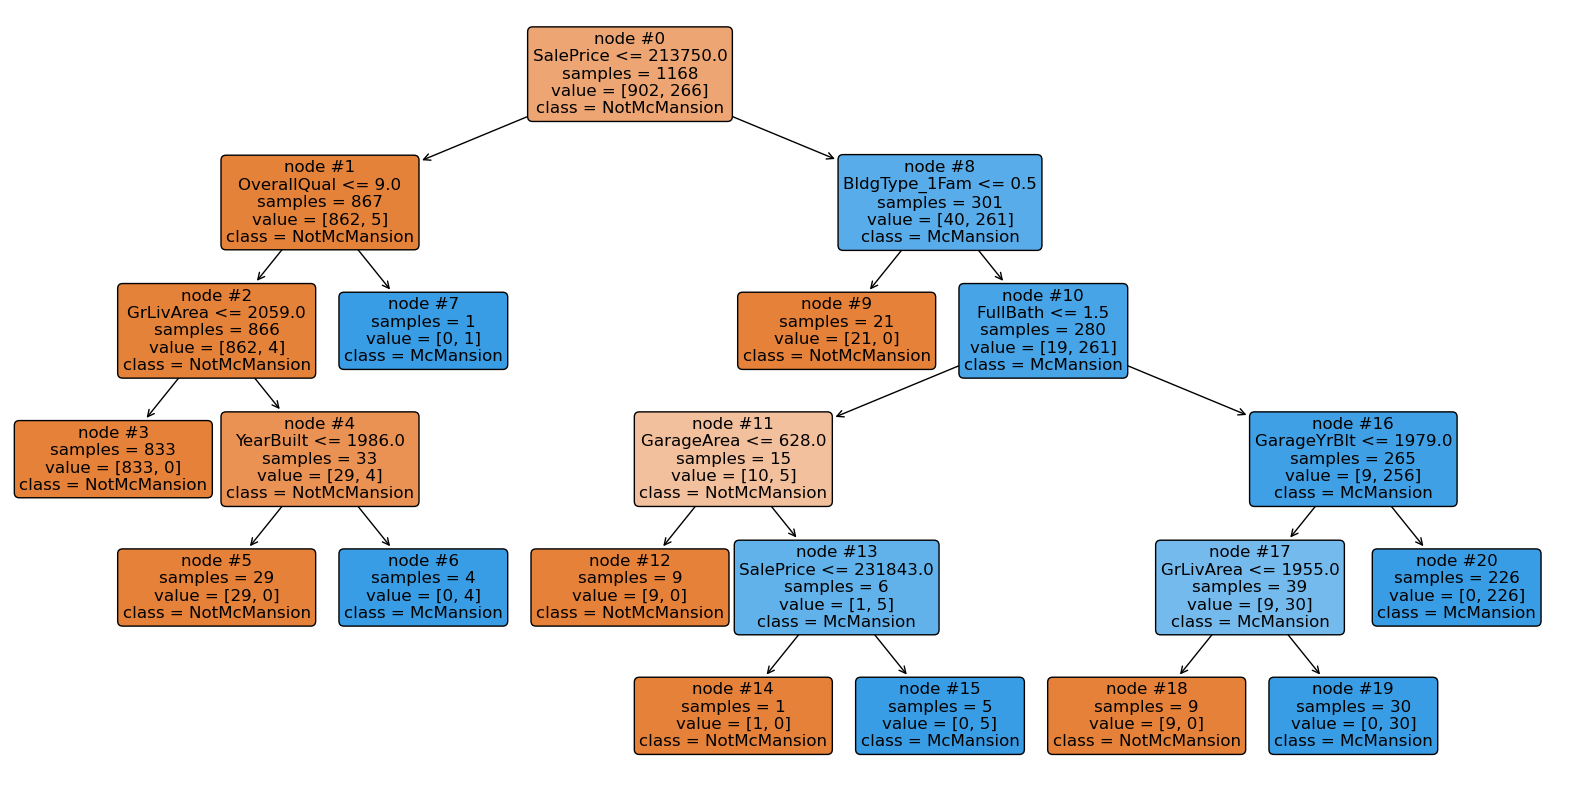

In [35]:
colors = ["red", "blue"]
classes = ["NotMcMansion", "McMansion"]
fig = plt.figure(figsize=(20, 10))
_ = plot_tree(model, filled=True, feature_names=features,
              class_names=classes, label='all',
              fontsize=12, precision=2, impurity=False,
              node_ids=True, rounded=True)

##### What can we infer?
While the results are similar the results of our regression model, there are some differences in the features that were chosen. In addition, the decision tree displays the thresholds for key values that make a difference in classifications for a specific field. 

* Sales price is the most important feature, but there were a few McMansions that were less than the threshold of \\$213K.

* It also makes sense that being a single family home was an important feature, given our decision rules earlier.

* When determining if a home was a McMansion, features pertaining to size/living area, as well as amenities (`GarageYrBlt`, `FullBath`) were very important. 

## Explaining Our Interpretation
Let's gather the inferences that we have collected to illustrate the big picture:

* We can be fairly confident in the result, because the accuracy is pretty high, because both models had a high accuracy score. __It will be important to validate these results on a hold-out dataset__.
* Both models had higher precision than recall, which suggests that the model may be slightly more specifc than sensitive. In other words, we are more likely to see a false negative than a false positive. __The class imbalance in the data might contribute to this__.
* In both models, the year built was a dominant feature to positively identify McMansions. However, we also saw that features that would be correlated with size and sale price were also important. __We should identify if it is the size these features are adding or the features themselves that is most important__. 

As we mentioned earlier, building decision engines and other machine learning models is an iterative process. Our interpretation of our white-box model allows us to explore this problem from many angles. You may notice that in bold, ideas that pertain to __future work__ are highlighted. The observations that we collected from this first iteration will guide our next steps as we improve our model. 

## Summary
In this lesson, we explored a use-case for white-box models in housing development, and demonstrated how you can use white-box models like logistic regression and decision trees to build a decision engine in scikit-learn. Then we discussed which metrics can be used in scikit-learn to interpret the results. We explained how evaluation metrics can contribute to the confidence we have in our results, and how coefficients and feature importance can help us to understand the most important features in the decision mechanism. In addition, we can use visualizations like bar plots and tree plots and communicate these findings in an intuitive way.

Our decision engine did a pretty good job classifying homes in the Ames Housing Dataset as McMansions. This first iteration achieved a reasonable degree of accuracy and the results make sense based on what we already understand about McMansions. The next step is to review each of our inferences and identify any areas of uncertainty to explore them further. For example, our regression model indicated via the coefficients that the exterior material of a home is an important feature. Our next iteration might include a deep dive into the distribution of exterior materials among our McMansions.